# **Laboratorio 4: Detector de Bordes Canny**

En el laboratorio anterior aplicaste filtros de paso alto para acentuar características en una imagen o encontrar sus bordes. Esta vez, aplicaremos filtros de paso bajo que te permitirán suavizar la imagen para minimizar los elementos de alta frecuencia. En este laboratorio, trabajaras principalmente con imágenes ruidosas ya que estas implican desafíos al momento de mejorarlas. A continuación, veras la combinación de filtros de paso bajo y alto integrados al método de detección de bordes Canny. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import numpy as np

## **Ejercicio 1:** Filtros de paso bajo
Cuanto más reciente sea el método, mejores serán los resultados del filtrado de paso bajo. Ahora, es tu turno de implementar los siguientes filtros desde cero. Para este ejercicio, puedes utilizar la función de filtrado que creaste en el último laboratorio.

- Filtro de la media
- Filtro de la mediana 
- Filtro gaussiano (puedes usar kernels con valores constantes)

Para probar tus metodos, deberas utiizar imágenes con ruido en escala de grises.

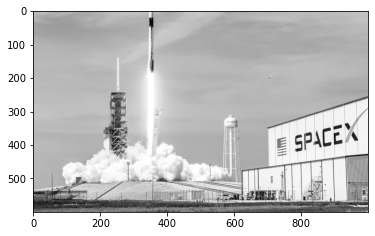

In [2]:
# Lectura de la imagen
image = mpimg.imread('SpaceX.jpg')

# Conversión a escala de grises para filtrar
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray, cmap="gray")

## **Ejercicio 2:** Procesamiento de Imágenes Médicas

Un médico diagnosticó a un paciente con un tumor benigno, el cual requiria una cirugía urgente para evitar que empeorara. Después, la cirugía se completó con éxito y se le solicitó al paciente que se realizara exámenes de tomografía computarizada todos los meses. El primer examen estuvo bien pero, lamentablemente, el equipo de análisis de imágenes computarizado se averio.

¿Puedes darles una mano?
Limpia la imagen y detecta los bordes. Al final, deberías obtener dos imagenes separadas, una con el examen anterior y otra imagen con el nuevo examen. Ambas imágenes deben estar binarizadas y solo con bordes.

No es necesario que diagnostiques la imagen todavía (es decir, identificar automáticamente si el paciente ha mejorado), pero puedes ayudar mostrando la ubicación del tumor en la muestra anterior. **Pista:** Puede usar cv.rectangle() o cv.circle() para marcar rectángulos y círculos en una imagen, respectivamente.

Deberas trabajar con la siguiente imagen: https://drive.google.com/file/d/1pV8_cUtI70tNNTL-o-ZPyK-tU0fOwv3t/view?usp=sharing 

## **Ejercicio 3:** Encuentra las gradientes

Encontrar las gradientes (bordes de una imagen) es un paso esencial del detector Canny. En este ejercicio deberas procesar una imagen y encontrar la magnitud y orientación de la gradiente por cada pixel. Tu método debería devolver dos imágenes resultantes (similares a la imagen ejemplo) despues de extraer las gradientes. Finalmente, deberas encontrar, filtrar y mostrar a todos los gradientes que esten apuntando al norte en una tercera imagen.